![cover](./images/cover.jpg) **Author: Juan Acosta**

## Business understanding

In recent years, the video game industry has seen a significant shift towards digital sales, with a majority of global revenue coming from digital channels. In 2022, it is estimated that over 75% of global video game revenue was generated through digital sales([source](https://www.pushsquare.com/news/2022/07/nearly-80percent-of-all-ps5-ps4-games-are-bought-digitally)), indicating a strong trend towards online purchasing and digital distribution of games. This shift towards digital sales is likely driven by a number of factors, including the increasing prevalence of high-speed internet and the convenience of being able to purchase and download games directly to a device without the need for physical copies. As the video game industry continues to evolve and technology advances, it is likely that digital sales will continue to grow in importance.

Video game recommendation systems are useful because they can help players discover new games that they might enjoy based on their past behavior and preferences. In a market where there are thousands of available games, it can be overwhelming for players to go through all of the options and find something that suits their interests. A recommendation system can help narrow down the options and suggest games that are more likely to be of interest to the user. A potential issue with recommender systems on official platform stores for digital games is that they may prioritize promoting newer games that are more profitable for the store, potentially at the expense of recommending older but high-quality games. This can lead to customers missing out on discovering older games that they might enjoy. It is important to be aware of this potential bias and to consider using other sources of recommendations in addition to the official platform store's.

## motivation

## Data understanding

To build a recommendation system, I used a dataset containing reviews from over 112,000 customers on more than 7,000 different game titles, for a total of over 140,000 reviews. Using the pandas library in Python, I began by performing exploratory data analysis (EDA) on the dataset, focusing on the columns that would be used as input for the recommendation algorithm. This process involved cleaning and preprocessing the data, identifying any patterns and selecting appropriate features for the model.

Amazon reviews dataset on kaggle [here](https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset?select=amazon_reviews_us_Digital_Video_Games_v1_00.tsv)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_raw = pd.read_csv('./data/Digital_Video_Games.tsv', sep='\t', header=0, error_bad_lines=False)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144724 entries, 0 to 144723
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        144724 non-null  object
 1   customer_id        144724 non-null  int64 
 2   review_id          144724 non-null  object
 3   product_id         144724 non-null  object
 4   product_parent     144724 non-null  int64 
 5   product_title      144724 non-null  object
 6   product_category   144724 non-null  object
 7   star_rating        144724 non-null  int64 
 8   helpful_votes      144724 non-null  int64 
 9   total_votes        144724 non-null  int64 
 10  vine               144724 non-null  object
 11  verified_purchase  144724 non-null  object
 12  review_headline    144722 non-null  object
 13  review_body        144722 non-null  object
 14  review_date        144721 non-null  object
dtypes: int64(5), object(10)
memory usage: 16.6+ MB


In [3]:
df_raw.isna().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      2
review_body          2
review_date          3
dtype: int64

### Columns
- **marketplace**: 2 letter country code of the marketplace where the review was written.
- **customer_id**: Random identifier that can be used to aggregate reviews written by a single author.
- **review_id**: The unique ID of the review.
- **productid**: The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same productid.
- **product_parent**: Random identifier that can be used to aggregate reviews for the same product.
- **product_title**: Title of the product.
- **product_category**: Broad product category that can be used to group reviews (also used to group the dataset into coherent parts).
- **star_rating**: The 1-5 star rating of the review.
- **helpful_votes**: Number of helpful votes.
- **total_votes**: Number of total votes the review received.
- **vine**: Review was written as part of the Vine program.
- **verified_purchase**: The review is on a verified purchase.
- **review_headline**: The title of the review.
- **review_body**: The review text.
- **review_date**: The date the review was written.

In [4]:
df_raw['marketplace'].unique()

array(['US'], dtype=object)

All reviews in dataset are from US customers

In [5]:
df_raw['customer_id'].nunique()

112891

112891 different customers 

In [6]:
df_raw['review_id'].nunique()

144724

Seems like there are no duplicate reviews in the set

In [7]:
df_raw['product_id'].nunique()

7939

7939 different products, but not all video games, found "Playstation Plus Subscription" in row 3, so all digitally sold products related video games, like subscriptions, seem to be included in the data set, will further look for other kind of product other than games and drop those.

In [8]:
df_raw['product_parent'].nunique()

7755

- **product_parent**: Random identifier that can be used to aggregate reviews for the same product.

seems like just another id but we have about 200 less data points in this column than product id

In [9]:
df_raw['product_title'].nunique()

6946

If i have 6946 different titles, i would expect the same amount of product_id, wonder if by droping everything that is not a game, like substriptions, would fix this discrepancy.

In [10]:
df_raw.iloc[3]['product_title']

'Playstation Plus Subscription'

It doesnt specify if the subscription is for 1, 3 or 12 months

<br>

Below i used key words to look for any products that is not a game
e.g
- Subscription
- Month
- Membership
- Card
- Network



In [11]:
def look_keyword(data, strg):
    content = data[data['product_title'].str.contains(strg)]
    print(f'Number of reviews for "{strg}" items: {len(content)} \n')
    
look_keyword(df_raw, "Subscription")    
look_keyword(df_raw, "Month")
look_keyword(df_raw, "Membership")
look_keyword(df_raw, "Card")
look_keyword(df_raw, "Network")

Number of reviews for "Subscription" items: 12137 

Number of reviews for "Month" items: 630 

Number of reviews for "Membership" items: 275 

Number of reviews for "Card" items: 21173 

Number of reviews for "Network" items: 13613 



In [12]:
df_raw['star_rating'].unique()
#games were rated in a scale of 1 to 5 stars

array([2, 5, 4, 1, 3])

In [13]:
df_raw['review_date'] = pd.to_datetime(df_raw['review_date'])
print(f'All reviews date back from {df_raw.review_date.min().year} to {df_raw.review_date.max().year}')

All reviews date back from 2006 to 2015


## Data Preparation

In [14]:
#Droping all rows that have strings: Subscription, Month, Membership,Network on the product_title column
df_raw_noSub = df_raw[df_raw["product_title"].str.contains("Subscription|Month|month|Membership|Network|Credit|Season Pass|Xbox Music Pass|Virtual Currency") == False]


Season Pass, Xbox Music Pass and Virtual Currency are some of the other kind of items on the dataset, i simply added them on the line above as i kept finding more during the process

For titles that have string 'Card' in the title, i have to be more careful since there are some game that include that on their name

In [15]:
def show_keyword(data, strg):
    """
    func just to show examples of titles with given string,
    to find any non-game items in the set
    """
    content = data[data['product_title'].str.contains(strg)]
    return content['product_title'].unique()[:10]
    
    
show_keyword(df_raw_noSub, 'Card')

array(['Xbox Live Gift Card', 'Xbox 360 Live Points Card',
       'Grand Theft Auto V Cash Cards', 'Hoyle Card Games 2012 AMR',
       'Final Fantasy XIV Online: 60 Day Time Card [Online Game Code]',
       'Hoyle Card Games  [Download]',
       'Xbox $5 Gift Card - Xbox 360 Digital Code',
       "Hoyle Kid's Card Games [Download]",
       'Legends of Solitaire: The Lost Cards [Download]',
       'Xbox $15 Gift Card (Call of Duty Ghosts:\xa0Onslaught DLC) - Xbox 360 Digital Code'],
      dtype=object)

First i will drop rows where 'Gift Card' is found, then i will proceed with other common combinations of words like 'Xbox Live' and Live Points Card

In [16]:
df_raw_noSub2 = df_raw_noSub[df_raw_noSub["product_title"].str.contains("Gift Card|Xbox Live|Live Points Card|Xbox Live Gift Card|Grand Theft Auto V Cash Cards|60 Day Time Card") == False]

show_keyword(df_raw_noSub2, 'Card')

array(['Hoyle Card Games 2012 AMR', 'Hoyle Card Games  [Download]',
       "Hoyle Kid's Card Games [Download]",
       'Legends of Solitaire: The Lost Cards [Download]',
       'Tripeaks Solitaire Multi (Tripeaks with Multiple Card-Sets and Multiple Layouts) [Download]',
       'Reel Deal Card Games 2011 [Download]',
       '2,013 Card, Mahjongg & Solitaire Games [Download]',
       'Hoyle Card Games [Mac Download]', 'Five Card Deluxe [Download]',
       "King's Collection: 6 Classic Card Games"], dtype=object)

Seems like all items left that include "card" in the title are actual games

<br>

Lets look for DLCs

In [17]:
DLC = df_raw_noSub2[df_raw_noSub2['product_title'].str.contains('DLC')]
print(f"Total number of DLCs: {DLC['product_title'].nunique()}")
print(f'Total number of DLC reviews:{len(DLC)}')

Total number of DLCs: 212
Total number of DLC reviews:1698


We have 212 different DLCs, and 1698 reviews, an original copy of the first game is required to be able to run a DLC, I will drop these too.

In [18]:
df_raw_noSub_no_DLC = df_raw_noSub2[df_raw_noSub2["product_title"].str.contains("DLC|Pack") == False]

Quantity for product id and product title still doesn't match

<br>

Some games include a substring next to the title, it describes the way buyers could access the game, for example:

`18 Wheels of Steel American Long Haul [Download]`

`18 Wheels of Steel American Long Haul [Online Game Code]`

Definitely the same game, just different "delivery" method.


In [19]:
df_raw_noSub_no_DLC[df_raw_noSub_no_DLC['product_title'].str.contains('18 Wheels of Steel American Long Haul')].head(3)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
39224,US,36420328,R2LOZS1XJTWZNN,B004GHNG0E,614285704,18 Wheels of Steel American Long Haul [Download],Digital_Video_Games,4,0,0,N,Y,Four Stars,ok,2014-10-15
50242,US,17845931,R2TJLHZ9X7EG83,B004GHNG0E,614285704,18 Wheels of Steel American Long Haul [Download],Digital_Video_Games,4,0,0,N,Y,Four Stars,Like driving trucks.,2014-07-14
74152,US,21374226,R388BHLY4GIU5E,B00CLVZGPK,775610170,18 Wheels of Steel American Long Haul [Online ...,Digital_Video_Games,1,1,1,N,Y,"Doesn't work, no manufacturer support",The code I got does not work. Amazon referred ...,2013-12-29



<br>

The `[Download]` edition of the game, on the second row above, has a different `product_id` than its `[Online Game Code]` edition (on the 3rd row above), it's the same game but taged with different ID, `product_parent` number is also different

<br>

I find it easier to modify the name than the id number, i need to group those reviews togeter, the delivery method doesnt change the software performance, so the review for a specific version is still relevant for a different one.

<br>

At first sight, `[Instant Access]`, `[Download]`, `[Digital Code]`, `[Game Connect]` and `[Online Game Code]` seem to be the most frequent tags at the end of the games titles, if i delete those out of the title name, i could use them for the rec system instead of the id, which was my first option

In [20]:
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['product_title'].str.replace(" \[Instant Access\]", "")
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" \[Download\]", "")
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" \[Game Connect\]", "")
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" \[Online Game Code\]", "")
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" \[Digital Code\]", "")

<ipython-input-20-de3b04f97402>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['product_title'].str.replace(" \[Instant Access\]", "")
<ipython-input-20-de3b04f97402>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" \[Download\]", "")
<ipython-input-20-de3b04f97402>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

The first title (on index 0) has 'Xbox One Digital Code' in its name, will check if there are more games with this same substring, or even for a different platform other than xbox

In [21]:
#below i deleted the susbstring using same method as before
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" - Xbox One Digital Code", "")

#found it for the 360 console too
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" - Xbox 360 Digital Code", "")

#found ' - PS4', ' - PS3', ' - PS Vita / PS4 / PS3', ' - PS Vita'
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" - PS Vita / PS4 / PS3", "")
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" - PS Vita", "")
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" - PS3", "")
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" - PS4", "")

<ipython-input-21-b0f23e8e230f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" - Xbox One Digital Code", "")
<ipython-input-21-b0f23e8e230f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" - Xbox 360 Digital Code", "")
<ipython-input-21-b0f23e8e230f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

### Clean DF

In [22]:
#New frame with cleaned data and only columns needed
Df_clean = df_raw_noSub_no_DLC[['customer_id', 'clean_title', 'star_rating']]
#reseting index
Df_clean.reset_index(drop=True, inplace=True)

print(f'Total number of customers in dataset:{Df_clean.customer_id.nunique()}')
print(f'Total number of games in dataset:{Df_clean.clean_title.nunique()}')

Total number of customers in dataset:76853
Total number of games in dataset:6000


In [941]:
# Subsetting to remove the customers with less than 3 reviews
Df_clean_subset = Df_clean[Df_clean['customer_id'].map(Df_clean['customer_id'].value_counts()) >= 3]

print(f'Total number of customers in dataset:{Df_clean_subset.customer_id.nunique()}')
print(f'Total number of games in dataset:{Df_clean_subset.clean_title.nunique()}')
print((f'Total number of reviews/ratings in dataset:{len(Df_clean_subset)}'))

Total number of customers in dataset:4191
Total number of games in dataset:4126
Total number of reviews/ratings in dataset:21471


 increasing the minimun number of reviews to keep the customers data in the subset will reduce RMSE in the model, but it gets rid of rating variaty of certain games, leaving me with only positive ratings for some of them, resulting in predictions were the same games were being recommended to everybody

In [942]:
#Saving as new file
Df_clean_subset.to_csv('./data/GameRatings.csv', index=False)
Ratings = pd.read_csv('./data/GameRatings.csv')

### Preparing for modeling

In [943]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

# Creating reader object and loading data in new format
reader = Reader(line_format='user item rating',
                sep=',', 
                rating_scale=(1, 5))

data = Dataset.load_from_df(Ratings[['customer_id', 'clean_title', 'star_rating']], reader=reader)

# split data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2)

print('Number of users: ', trainset.n_users)
print('Number of items: ', trainset.n_items)
print('Number of ratings: ', trainset.n_ratings)

Number of users:  4170
Number of items:  3797
Number of ratings:  17176


# Modeling

To build the recommendation system, I am using scikit-surprise library in Python, which includes a range of algorithms and tools for building and evaluating recommendation models. Specifically, I will be using collaborative filtering techniques to make recommendations based on the similarity of users and items.

As a first step, I will train a model using a memory-based method, which utilizes the entire dataset to make predictions. After building the initial model, I will then explore the use of a model-based approach, which involves using machine learning algorithms to learn the underlying relationships in the data and make predictions. To tune the model and find the best set of hyperparameters, I will use grid search to try different combinations of parameters and evaluate their performance using root mean squared error.

In [ ]:
from surprise.prediction_algorithms import *
from surprise import accuracy
from surprise.model_selection import cross_validate, GridSearchCV

## KNN Baseline Model

In [865]:
KNNbaseline_model = KNNBaseline()
KNNbaseline_model.fit(trainset)

#getting predictions using testset
KNNb_predictions = KNNbaseline_model.test(testset)

# Root Mean Square Error and Mean Absolute Error
accuracy.rmse(KNNb_predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3303
MAE:  1.0264


1.0264336739220996

**Cross validation**

In [866]:
KNNb_cv = cross_validate(algo = KNNbaseline_model, 
                         data = data, 
                         measures=['RMSE'], 
                         cv=5, 
                         n_jobs= -2,
                         return_train_measures=True, 
                        verbose=True)

Evaluating RMSE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3489  1.3222  1.3394  1.3350  1.3387  1.3368  0.0086  
RMSE (trainset)   0.4263  0.4234  0.4234  0.4226  0.4256  0.4243  0.0014  
Fit time          0.85    0.84    0.87    0.85    0.73    0.83    0.05    
Test time         0.10    0.10    0.09    0.09    0.10    0.10    0.00    


## Baseline model

As a starting point for comparison, I selected NormalPredictor as the baseline model. All other models will be compared to it using root mean squared error as the evaluation metric

In [896]:
# Instantiate and fit model
baseline = NormalPredictor()
baseline.fit(trainset)

# Return test predictions for model fit on trainset
base_pred = baseline.test(testset)

# Save RMSE score to variable
accuracy.rmse(base_pred)

RMSE: 1.7792
MAE:  1.3998


1.399803304549392

## SVD Simple model

To start, I will implement a basic version of the SVD algorithm, which gained popularity due to Simon Funk's use of it in the Netflix Prize competition. This algorithm is well-known for its effectiveness in matrix factorization. In order to fine-tune the model's performance, I will utilize grid search to identify the optimal hyperparameters. To ensure that my results can be reproduced, I will consistently set the random state to 40 for all future models

In [912]:
SVD_model = SVD(random_state=40)
SVD_model.fit(trainset)

#getting predictions using testset
SVD_predictions = SVD_model.test(testset)

# Root Mean Square Error and Mean Absolute Error
accuracy.rmse(SVD_predictions)

RMSE: 1.2348
MAE:  0.9920


0.9920075917343008

RMSE lower than baseline, will move on to gridsearches

### SVD Gridsearch

In [947]:
# Setting grid around default parameter values
SVD_grid = {'n_factors':[50, 100, 120],
           'n_epochs':[10, 20, 40],
           'lr_all':[0.002, 0.005, 0.05],
           'reg_all':[0.02, 0.1]}

SVD_gs = GridSearchCV(algo_class = SVD, 
                      param_grid = SVD_grid, 
                      measures=['rmse'], 
                      n_jobs = -2, 
                      joblib_verbose = 5, 
                     cv=3)

SVD_gs.fit(data)
SVD_gs.best_params['rmse']

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-2)]: Done 162 out of 162 | elapsed:   22.2s finished


{'n_factors': 100, 'n_epochs': 10, 'lr_all': 0.05, 'reg_all': 0.1}

In [934]:
# using best parameters in new model and only fiting train set
svd_1 = SVD(n_factors=100, n_epochs=10, lr_all=0.05, reg_all= .1, random_state=40)

svd_1.fit(trainset)

#getting predictions using testset
SVD_pred_1 = svd_1.test(testset)

# Root Mean Square Error and Mean Absolute Error
accuracy.rmse(SVD_pred_1)

RMSE: 1.2161


1.2161005578219166

Gridsearch improved RMSE from the baseline model. For the next iteration, I will try using more granular values around n_factors and lower values for n_epochs. Since the highest values for reg_all and lr_all were returned from the grid search, I will also include a higher value for these hyperparameters to test their effect on the model's performance

### SVD Gridsearch 2

In [948]:
SVD_grid_2 = {'n_factors':[70, 75, 82, 87, 95, 100, 108, 116], 
              'n_epochs':[2, 5, 9, 13, 15], 
              'lr_all':[0.02, .05, .07], 
              'reg_all':[0.05, 0.1, 0.2]}

SVD_gs_2 = GridSearchCV(algo_class = SVD, 
                      param_grid = SVD_grid_2, 
                      measures=['rmse'], 
                      n_jobs = -2, 
                      joblib_verbose = 5, 
                       cv=3)

SVD_gs_2.fit(data)
SVD_gs_2.best_params['rmse']

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-2)]: Done 274 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-2)]: Done 634 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-2)]: Done 868 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-2)]: Done 1080 out of 1080 | elapsed:  1.0min finished


{'n_factors': 70, 'n_epochs': 15, 'lr_all': 0.02, 'reg_all': 0.2}

In [950]:
# using best parameters in new model and only fiting train set
svd_2 = SVD(n_factors=70, n_epochs= 15, lr_all=0.02, reg_all= 0.2, random_state = 40)

svd_2.fit(trainset)

#getting predictions using testset
SVD_pred_2 = svd_2.test(testset)

# Root Mean Square Error and Mean Absolute Error
accuracy.rmse(SVD_pred_2)
accuracy.mae(SVD_pred_2)

RMSE: 1.2136
MAE:  0.9711


0.97113695495271

Gridsearch returned the lowest value for n_factors and lr_all, highest for n_epochs and reg_all

### SVD Gridsearch 3

In [951]:
SVD_grid_3 = {'n_factors':[40, 45, 50, 60, 65, 70],
           'n_epochs':[15, 17, 20],
           'lr_all':[0.005, 0.01, 0.02],
           'reg_all':[0.2, 0.3, 0.5]}

SVD_gs_3 = GridSearchCV(algo_class = SVD, 
                      param_grid = SVD_grid_3, 
                      measures=['rmse'], 
                      n_jobs = -2, 
                      joblib_verbose = 5, 
                       cv=3)

SVD_gs_3.fit(data)
SVD_gs_3.best_params['rmse']

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-2)]: Done 274 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-2)]: Done 486 out of 486 | elapsed:   33.9s finished


{'n_factors': 45, 'n_epochs': 17, 'lr_all': 0.02, 'reg_all': 0.3}

In [968]:
# using best parameters in new model and only fiting train set
svd_3 = SVD(n_factors=45, n_epochs= 17, lr_all=0.02, reg_all= 0.3, random_state=40)

svd_3.fit(trainset)

#getting predictions using testset
SVD_pred_3 = svd_3.test(testset)

# Root Mean Square Error and Mean Absolute Error
accuracy.rmse(SVD_pred_3)
accuracy.mae(SVD_pred_3)

RMSE: 1.2118
MAE:  0.9696


0.9695800655914475

In [969]:
SVD_cv3 = cross_validate(algo = svd_3, 
                        data = data, 
                        measures=['RMSE'], 
                        cv=5, 
                        n_jobs=-2, 
                        verbose=True, 
                        return_train_measures=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2266  1.1933  1.2275  1.2134  1.1900  1.2102  0.0159  
RMSE (trainset)   0.7741  0.7778  0.7741  0.7741  0.7805  0.7761  0.0026  
Fit time          0.36    0.37    0.37    0.37    0.38    0.37    0.01    
Test time         0.02    0.02    0.02    0.02    0.03    0.02    0.00    


RMSE is better than baseline model and basic SVD mode, i will move on to try a SVD++ model, it is an extension of SVD that incorporates additional information, such implicit feedback/ratings. It is designed to handle noisy and sparse data better than SVD

## SVD++

In [939]:
# Default hyperparameters
svdpp_Model = SVDpp(random_state=40)

svdpp_Model.fit(trainset)

#getting predictions using testset
SVDpp_pred = svdpp_Model.test(testset)

# Root Mean Square Error and Mean Absolute Error
accuracy.rmse(SVDpp_pred)
accuracy.mae(SVDpp_pred)

RMSE: 1.2187
MAE:  0.9720


0.9720208702808977

### SVD++ Gridsearch

In [940]:
# Setting grid around default parameter values
SVDpp_grid = {'n_factors':[1, 5, 15, 30], 
              'n_epochs':[10, 20, 40], 
              'reg_all':[0.01, 0.02, 0.05], 
             'lr_all':[0.003, 0.007, 0.01]}


SVDpp_gs = GridSearchCV(algo_class = SVDpp, 
                        param_grid = SVDpp_grid, 
                        measures=['rmse'], 
                        n_jobs = -2, 
                        cv=3, 
                        joblib_verbose = 5)


SVDpp_gs.fit(data)
SVDpp_gs.best_params['rmse']

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-2)]: Done 274 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done 324 out of 324 | elapsed:  1.8min finished


{'n_factors': 1, 'n_epochs': 40, 'reg_all': 0.05, 'lr_all': 0.007}

In [944]:
svdpp_1 = SVDpp(n_factors=1, n_epochs=40, reg_all=0.05, lr_all=0.007, random_state=40)

svdpp_1.fit(trainset)

#getting predictions using testset
SVDpp_pred_1 = svdpp_1.test(testset)

# Root Mean Square Error and Mean Absolute Error
accuracy.rmse(SVDpp_pred_1)
accuracy.mae(SVDpp_pred_1)

RMSE: 1.2160
MAE:  0.9602


0.960180808818546

### SVD++ Gridsearch 2

Setting n_factors and n_epochs around lower and higher values respectively

In [945]:
SVDpp_grid_2 = {'n_factors':[1, 3, 5, 7, 9, 10], 
              'n_epochs':[30, 35, 40, 45, 50], 
              'reg_all':[0.03, 0.07, 0.1], 
             'lr_all':[0.007]}


SVDpp_gs_2 = GridSearchCV(algo_class = SVDpp, 
                        param_grid = SVDpp_grid_2, 
                        measures=['rmse'], 
                        n_jobs = -2, 
                        cv=3, 
                        joblib_verbose = 5)


SVDpp_gs_2.fit(data)
SVDpp_gs_2.best_params['rmse']

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done 270 out of 270 | elapsed:  2.0min finished


{'n_factors': 1, 'n_epochs': 40, 'reg_all': 0.1, 'lr_all': 0.007}

In [972]:
SVDpp_2 = SVDpp(n_factors=1, n_epochs=40, reg_all=0.1, lr_all=0.007, random_state=40)

SVDpp_2.fit(trainset)

#getting predictions using testset
SVDpp_pred_2 = SVDpp_2.test(testset)

# Root Mean Square Error and Mean Absolute Error
accuracy.rmse(SVDpp_pred_2)

RMSE: 1.2141


1.2140603163440107

In [973]:
SVDpp_2_cv = cross_validate(algo = SVDpp_2, 
                        data = data, 
                        measures=['RMSE'], 
                        cv=5, 
                        n_jobs=-2, 
                        verbose=True, 
                        return_train_measures=True)

Evaluating RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2347  1.2055  1.1792  1.2207  1.2180  1.2116  0.0187  
RMSE (trainset)   0.8985  0.9005  0.9042  0.8942  0.8914  0.8977  0.0045  
Fit time          2.94    2.97    3.01    2.93    2.95    2.96    0.03    
Test time         0.07    0.06    0.06    0.06    0.06    0.06    0.00    


# Model Evaluation

In [999]:
%%capture
#preparing all models' RMSE for plotting
model_pred = [KNNb_predictions, base_pred, SVD_predictions, SVD_pred_3, SVDpp_pred, SVDpp_pred_2]

model_names = ['KNNb', 'Baseline', 'SVD simple', 'SVD GS3', 'SVDpp', 'SVDpp GS2']
RMSE_values = []
for X in model_pred:
    RMSE_values.append(round(float(accuracy.rmse(X)), 4))

zipped_dict = {x:z for x, z in zip(model_names,RMSE_values)}

sort_zip = dict(sorted(zipped_dict.items(), key=lambda item: item[1], reverse=True))

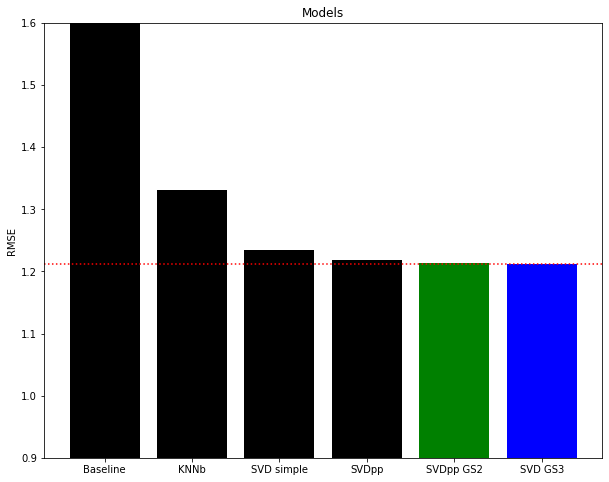

In [1001]:
best_model_rmse = sort_zip['SVD GS3']

fig, ax = plt.subplots(figsize=(10,8))
plt.bar(sort_zip.keys(), sort_zip.values(), color=['Black', 'black', 'black', 'black', 'green', 'blue'])
plt.ylim(.9, 1.6)
plt.axhline(y = best_model_rmse, color = 'r', linestyle = 'dotted')
ax.set_title("Models")
plt.ylabel('RMSE');
# plt.savefig('images/Model_Evaluation.png', dpi=600, bbox_inches='tight');

To evaluate the performance of different models, I used the RMSE as the metric of choice. After analyzing the results, it was found that the SVD model with hyperparameters from the third grid search achieved the best performance, with an RMSE of 1.2118. This value is lower than the RMSE of 1.7792 produced by the baseline model, indicating a significant improvement.

While SVD++ models also demonstrated an improvement compared to the baseline model, it should be noted that they are more computationally expensive as demonstrated by the cross validation results

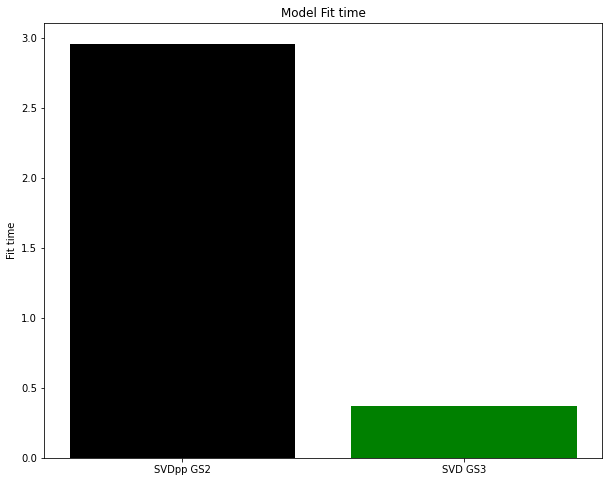

In [1010]:
fig, ax = plt.subplots(figsize=(10,8))

plt.bar(x= ['SVDpp GS2', 'SVD GS3'], 
        height=[np.mean(SVDpp_2_cv['fit_time']), np.mean(SVD_cv3['fit_time'])], 
        color=['black', 'green'])

plt.ylim()
ax.set_title("Model Fit time")
plt.ylabel('Fit time');
# plt.savefig('images/Model_Evaluation.png', dpi=600, bbox_inches='tight');

# Recommender System

Incorporate the optimized SVD model into a recommendation system

In [1020]:
# Creating a trainset in surprise format using the whole dataset
full_trainset = data.build_full_trainset()

# fit best model with full trainset
best_model = svd_3
best_model.fit(full_trainset)

In [1021]:
# Dataset with all customer id and games played/reviewed by each of them
customer_set = Ratings.set_index('customer_id')
customer_set.drop(columns='star_rating', inplace=True)


The system will only provide recommendations to existing customers whose data has been used to train the model. To receive recommendations, any new customers and their associated reviews must be added to the dataset and the model must be retrained.

In [1022]:
# Use the customer ID and desired number of recommendations as input for the system
customer = int(input('CustomerId: '))
nRec = int(input('Number of recommendations? '))

CustomerId: 40235215
Number of recommendations? 5


In [1023]:
# Creating list with games played/reviewed by customer
played = list(customer_set.loc[customer, 'clean_title'])

In [1024]:
# Creating new dataset with all games not played by the customer yet

# Dataset with unique game titles, dropping duplicates
unique_games = Ratings.drop_duplicates('clean_title')
game_indexed = unique_games.set_index('clean_title')

# Dropping games reviewd by customer
not_played = game_indexed.drop(played)

# Reset index to show titles on their own column
not_played.reset_index(inplace=True)

In [1025]:
# not_played list shoud have lest titles than game_set
len(not_played) < len(game_set)

False

**Getting raiting predictions**

In [1026]:
# Creating new column containing a predicted rating for each of the games not played by the customer
# using best_model.predict
not_played['prediction'] = not_played['clean_title'].apply(lambda x: best_model.predict(customer, x).est)

# Sort dataset based on predicted rating 
not_played.sort_values(by='prediction', ascending=False, inplace=True)

#renaiming clean_title column for readibility
not_played.rename(columns={'clean_title': 'Recommended Games'}, inplace=True)

# Only returning specified number of recomendations requested by user (nRec)
recommendation =  not_played['Recommended Games'].head(nRec)

**Display both played and recommended games together**

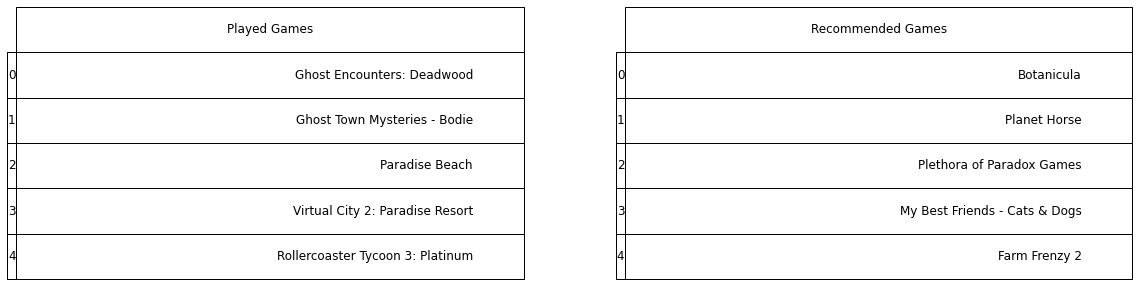

In [1028]:
#creating fig to display two dataframes next to eachother
fig = plt.figure(figsize=(20,5))


#creating new daframe using played list, using only game-name column for easy implementation below
#only displaying first 5 games played by user
p_df = pd.DataFrame(played, columns=(['Played Games'])).head()

#first ax will display games top games played by customer 
ax1 = fig.add_subplot(121)
font_size=12
bbox=[0, 0, 1, 1]
ax1.axis('off')
mpl_table = ax1.table(cellText = p_df.values, rowLabels = p_df.index, bbox=bbox, colLabels=p_df.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)


#creating new daframe using recommendation df, using only game-name column for easy implementation below
r_df = pd.DataFrame(recommendation)
r_df.reset_index(inplace=True, drop=True)

# on ax2 will display recommended games
ax2 = fig.add_subplot(122)
font_size=12
bbox=[0, 0, 1, 1]
ax2.axis('off')
mpl_table = ax2.table(cellText = r_df.values, rowLabels = r_df.index, bbox=bbox, colLabels=r_df.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

## Function

In [1029]:
def game_recommender():
    
    customer = int(input('Customer ID: '))
    nRec = int(input('Number of recommendations: '))
    
    
    # Creating list with games played/reviewed by customer
    played = list(customer_set.loc[customer, 'clean_title'])
    
    
    # Creating new dataset with all games not played by the customer yet
    # Dataset with unique game titles, dropping duplicates
    unique_games = Ratings.drop_duplicates('clean_title')
    game_indexed = unique_games.set_index('clean_title')

    # Dropping games reviewd by customer using index
    not_played = game_indexed.drop(played)

    # Reset index to show titles on their own column
    not_played.reset_index(inplace=True)
    
    # Creating new column containing a predicted rating for each of the games not played by the customer
    # using best_model.predict
    not_played['prediction'] = not_played['clean_title'].apply(lambda x: best_model.predict(customer, x).est)

    # Sort dataset based on predicted rating 
    not_played.sort_values(by='prediction', ascending=False, inplace=True)

    # renaiming clean_title column for readibility
    not_played.rename(columns={'clean_title': 'Recommended Games'}, inplace=True)
                                                    
    # Only returning specified number of recomendations requested by user (nRec)                   
    recommendation =  not_played['Recommended Games'].head(nRec)
    

    
    # creating fig to display two dataframes next to eachother
    fig = plt.figure(figsize=(20,5))


    # creating new daframe using played list, using only game-name column for easy implementation below
    # only displaying first 5 games played by user
    p_df = pd.DataFrame(played, columns=(['Played Games'])).head()

    # first ax will display games top games played by customer 
    ax1 = fig.add_subplot(121)
    font_size=12
    bbox=[0, 0, 1, 1]
    ax1.axis('off')
    mpl_table = ax1.table(cellText = p_df.values, rowLabels = p_df.index, bbox=bbox, colLabels=p_df.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)


    # creating new daframe using recommendation df, using only game-name column for easy implementation below
    r_df = pd.DataFrame(recommendation)
    r_df.reset_index(inplace=True, drop=True)

    # on ax2 will display recommended games
    ax2 = fig.add_subplot(122)
    font_size=12
    bbox=[0, 0, 1, 1]
    ax2.axis('off')
    mpl_table = ax2.table(cellText = r_df.values, rowLabels = r_df.index, bbox=bbox, colLabels=r_df.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

**Testing function**

In [531]:
# getting random sample of customer IDs
ID_sample = Ratings.sample(20)
ID_sample['customer_id'].values

array([ 2763599, 40902831, 36527466, 46796873, 48417142, 12307077,
       46332022, 39942708, 40847927, 52573695, 41370439, 52422920,
        1397995, 13621710, 43854644, 40235215, 47913319, 16065750,
       45221772, 40184619])

Customer ID: 50231542
Number of recommendations: 5


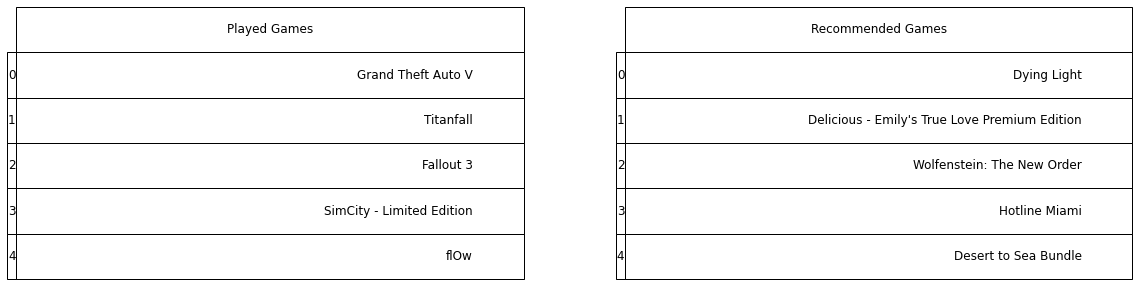

In [858]:
# recommendation for customer 50231542
game_recommender()

Customer ID: 22981757
Number of recommendations: 5


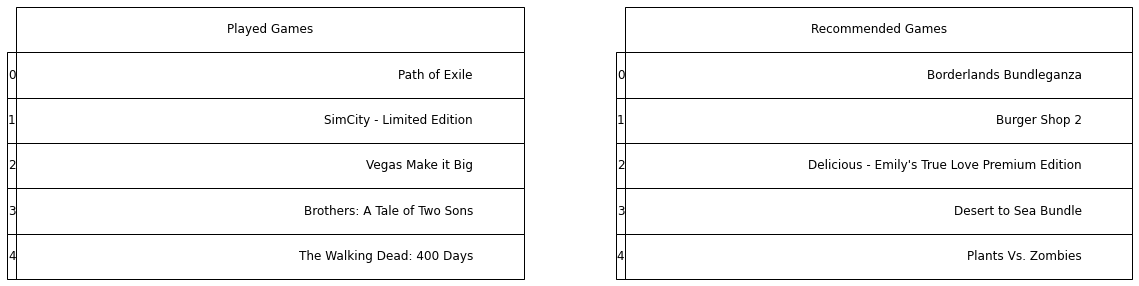

In [859]:
game_recommender()

Customer ID: 52422920
Number of recommendations: 5


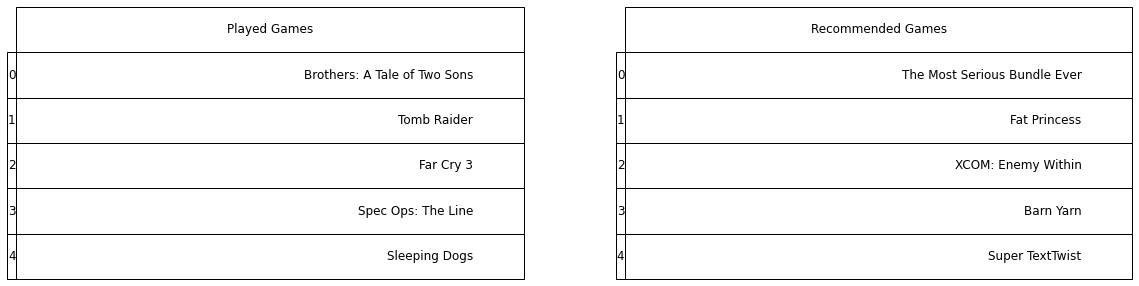

In [861]:
game_recommender()

## limitations


limitation collaborative filtering



## Deployment

## Resources

https://surprise.readthedocs.io/en/stable/dataset.html?highlight=build_full_trainset()#surprise.dataset.DatasetAutoFolds.build_full_trainset

https://towardsdatascience.com/svd-where-model-tuning-goes-wrong-61c269402919

https://sifter.org/~simon/journal/20061211.html

## metadata

!ls data


import gzip

vec_tfidf

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

meta_df = getDF('./data/meta_Video_Games.json.gz')